In [1]:
import pandas as pd, numpy as np, re, joblib, nltk, matplotlib.pyplot as plt, seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from scipy.sparse import hstack
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gurpr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
DATA_PATH = "../data/processed_disaster_tweets.csv"  
df = pd.read_csv(DATA_PATH)

print(f"Dataset shape : {df.shape}")
df.head()

Dataset shape : (7613, 9)


,id,keyword,location,text,target,clean_text,tokens,text_length,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"['deed', 'reason', 'earthquake', 'may', 'allah...",69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"['forest', 'fire', 'near', 'ronge', 'sask', 'c...",38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"['resident', 'asked', 'shelter', 'place', 'not...",133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,"['people', 'receive', 'wildfire', 'evacuation'...",65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"['got', 'sent', 'photo', 'ruby', 'alaska', 'sm...",88,16


# Add Sentiment Analysis Features

In [4]:
sia = SentimentIntensityAnalyzer()
sent = df['clean_text'].apply(lambda t: pd.Series(sia.polarity_scores(t)))
df = pd.concat([df, sent], axis=1)



# Add Metadata Features

In [6]:
# Tweet Length
df['char_count'] = df['text'].apply(len)

# Word count
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# Hashtag count
df['hashtag_count'] = df['text'].apply(lambda x: len(re.findall(r"#\w+", x)))

# Mention count
df['mention_count'] = df['text'].apply(lambda x: len(re.findall(r"@\w+", x)))

df[['char_count', 'word_count', 'hashtag_count', 'mention_count']].head()


,char_count,word_count,hashtag_count,mention_count
0,69,13,1,0
1,38,7,0,0
2,133,22,0,0
3,65,7,1,0
4,88,16,2,0


# TF-IDF Vectorization of Text

In [8]:
# Use already split clean text and labels
X_text = df['clean_text']
y = df['target']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Combine Text Features + Metadata + Sentiment

In [10]:
# Additional features
feature_cols = ['char_count', 'word_count', 'hashtag_count', 'mention_count',
                'neg', 'neu', 'pos', 'compound']

X_additional = df[feature_cols]
X_train_add, X_test_add = train_test_split(X_additional, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_add_scaled = scaler.fit_transform(X_train_add)
X_test_add_scaled = scaler.transform(X_test_add)

# Combine TF-IDF + other features
from scipy.sparse import hstack
X_train_final = hstack((X_train_tfidf, X_train_add_scaled))
X_test_final = hstack((X_test_tfidf, X_test_add_scaled))


# MODEL SELECTION & TRAINING

In [12]:
#Logistic Regression
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_final, y_train)

y_pred_lr = log_reg.predict(X_test_final)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.84      0.72      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



# Random Forest Classifier

In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_final.toarray(), y_train)

y_pred_rf = rf.predict(X_test_final.toarray())
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       869
           1       0.82      0.66      0.73       654

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



# Neural Network (MLPClassifier from Scikit-learn)

In [16]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=300)
mlp.fit(X_train_final, y_train)

y_pred_mlp = mlp.predict(X_test_final)
print("MLP Classifier Report:")
print(classification_report(y_test, y_pred_mlp))

MLP Classifier Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       869
           1       0.71      0.74      0.72       654

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



# Cross Validation

In [18]:

cv_scores = cross_val_score(log_reg, X_train_final, y_train, cv=5, scoring='f1')
print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())


Cross-validation F1 scores: [0.74019088 0.73482428 0.72435897 0.72881356 0.73917635]
Mean F1 score: 0.7334728082715511


# Hyperparameter Tuning (Random Search)

In [20]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=5,
    scoring='f1',
    cv=3,
    random_state=42
)

random_search.fit(X_train_final.toarray(), y_train)
print("Best Params:", random_search.best_params_)

best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_final.toarray())
print("Optimized RF Report:")
print(classification_report(y_test, y_pred_best_rf))


Best Params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': None}
Optimized RF Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.82      0.68      0.74       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [21]:

# Save best model 
joblib.dump(best_rf, '../models/best_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')

scaler = StandardScaler()
scaler.fit(df[feature_cols])       
joblib.dump(scaler, '../models/scaler.pkl')



print("Model, vectorizer, and scaler saved successfully.")


Model, vectorizer, and scaler saved successfully.


# Model Evaluation


In [23]:
# Assuming best_rf is the chosen model
y_pred = best_rf.predict(X_test_final.toarray())
y_proba = best_rf.predict_proba(X_test_final.toarray())[:, 1]  # Probabilities for ROC


# Classification Report

In [25]:


print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-disaster", "Disaster"]))

 Classification Report:
              precision    recall  f1-score   support

Non-disaster       0.79      0.88      0.83       869
    Disaster       0.82      0.68      0.74       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



# Confusion Matrix

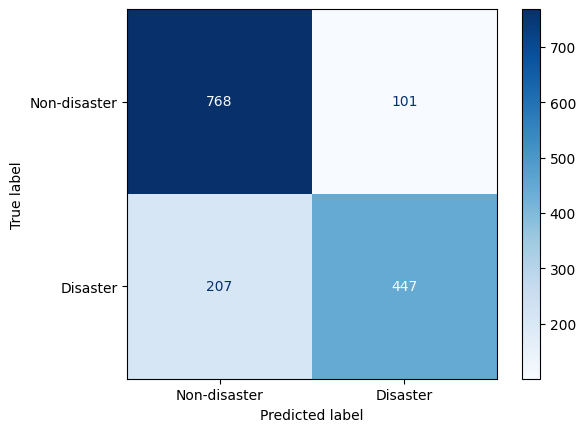

In [27]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-disaster", "Disaster"])
disp.plot(cmap="Blues")

# ROC Curve

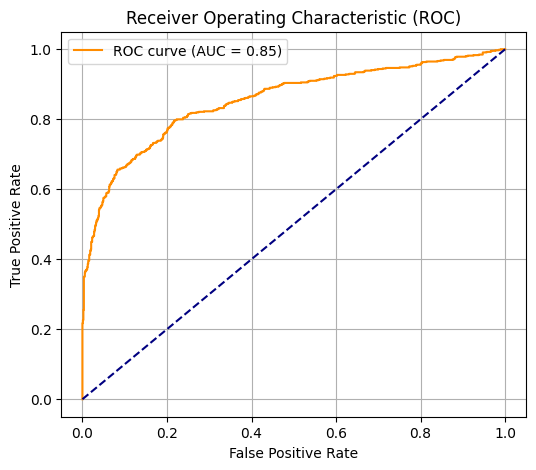

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.grid()
plt.show()


# Precision-Recall Curve

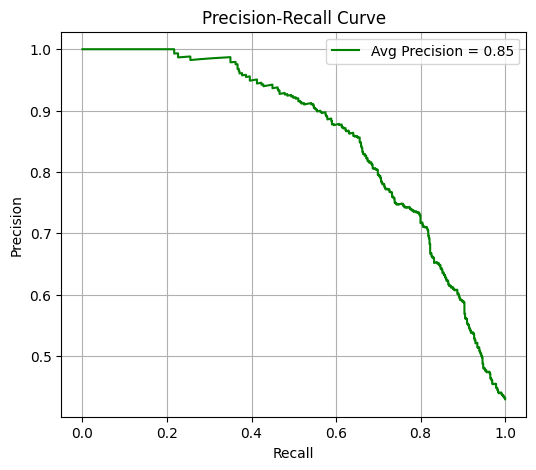

In [31]:


precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', label=f"Avg Precision = {avg_prec:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


# Model Comparison Summary

In [33]:
from sklearn.metrics import f1_score, accuracy_score

models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP Classifier': mlp
}

for name, model in models.items():
    pred = model.predict(X_test_final if name != 'Random Forest' else X_test_final.toarray())
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print(f"{name:20} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")


Logistic Regression  | Accuracy: 0.8194 | F1-Score: 0.7733
Random Forest        | Accuracy: 0.7919 | F1-Score: 0.7311
MLP Classifier       | Accuracy: 0.7571 | F1-Score: 0.7235


# Model Validation

In [35]:
# Check for Overfitting
from sklearn.metrics import accuracy_score, f1_score

train_pred = best_rf.predict(X_train_final.toarray())
test_pred = best_rf.predict(X_test_final.toarray())

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

Train Accuracy: 0.9901
Test Accuracy : 0.7978


In [36]:
sample_tweets = [
    "Huge earthquake just hit Mexico!",
    "I'm burning my pizza. What a disaster!",
    "Wildfire spreading in California.",
    "Feeling cold. Might stay in bed."
]

# Clean tweets inline (if clean_text isn't available)
basic_clean = lambda s: re.sub(
    r'[^a-z\s]', ' ',
    re.sub(r'https?://\S+|www\.\S+|@\w+|#', ' ', s.lower())
).strip()

sample_cleaned = [basic_clean(t) for t in sample_tweets]
tfidf_input = tfidf.transform(sample_cleaned)

#  Define and enforce correct feature order
feature_cols = ['char_count', 'word_count', 'hashtag_count', 'mention_count',
                'neg', 'neu', 'pos', 'compound']

# Create metadata in exact order
sample_meta = pd.DataFrame({
    'char_count': [len(t) for t in sample_tweets],
    'word_count': [len(t.split()) for t in sample_tweets],
    'hashtag_count': [len(re.findall(r"#\w+", t)) for t in sample_tweets],
    'mention_count': [len(re.findall(r"@\w+", t)) for t in sample_tweets],
    'neg': [0.1]*4,
    'neu': [0.8]*4,
    'pos': [0.1]*4,
    'compound': [0.0]*4
})[feature_cols]  # enforce order

# Scale numeric features using trained scaler
scaled_meta = scaler.transform(sample_meta[feature_cols])

# Combine with TF-IDF
from scipy.sparse import hstack
final_input = hstack((tfidf_input, scaled_meta))

# Predict
preds = best_rf.predict(final_input)
for text, label in zip(sample_tweets, preds):
    print(f"[{'Disaster' if label else 'Non-Disaster'}] ➜ {text}")

[Non-Disaster] ➜ Huge earthquake just hit Mexico!
[Non-Disaster] ➜ I'm burning my pizza. What a disaster!
[Disaster] ➜ Wildfire spreading in California.
[Disaster] ➜ Feeling cold. Might stay in bed.
